In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go

from sklearn.cluster import KMeans

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from warnings import filterwarnings
filterwarnings('ignore')

# Loading the Data

In [2]:
df = pd.read_csv('HR_comma_sep.csv')

In [4]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


# 1. Checking missing values

In [10]:
df.isna().sum()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

**Since we can clearly see, there is no missing value in our dataset**

# 2. Exploratory Data Analysis

<Axes: >

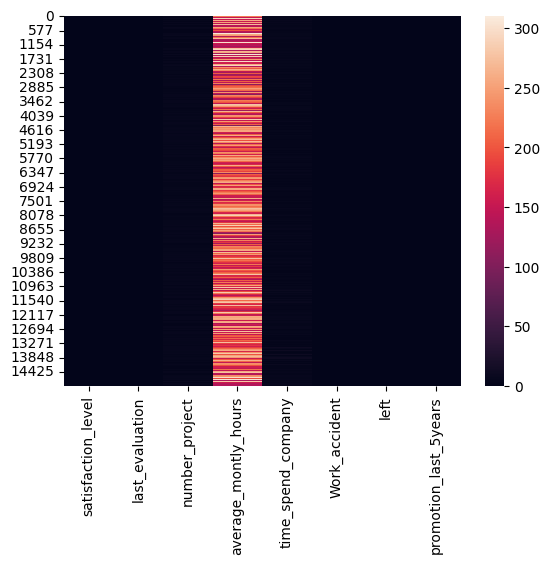

In [13]:
sns.heatmap(df.drop(['department', 'salary'], axis=1))

**The heatmap you have provided represents the correlation matrix between all numerical columns in the dataset. Each cell in the heatmap indicates the strength and direction of the relationship between two features, with the color intensity varying according to the correlation coefficient.**

**Lighter colors (closer to white) represent higher correlations (closer to 1 or -1), suggesting a strong positive or negative relationship between the respective features. Darker colors (closer to black) represent weaker correlations (closer to 0), indicating little or no linear relationship between the features.**

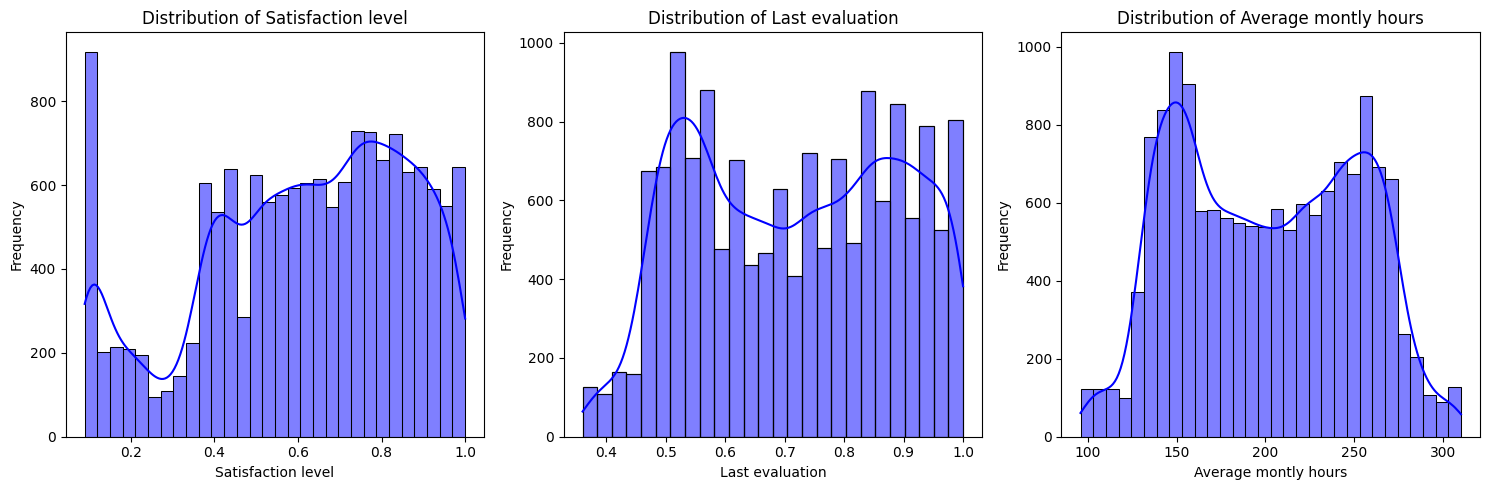

In [17]:
# Defining the columns to plot
columns_to_plot = ['satisfaction_level', 'last_evaluation', 'average_montly_hours']

# Creating distribution plots for each column
plt.figure(figsize=(15, 5))

for i, column in enumerate(columns_to_plot):
    plt.subplot(1, 3, i + 1)
    sns.histplot(df[column], kde=True, color='blue')
    plt.title(f'Distribution of {column.replace("_", " ").capitalize()}')
    plt.xlabel(column.replace("_", " ").capitalize())
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

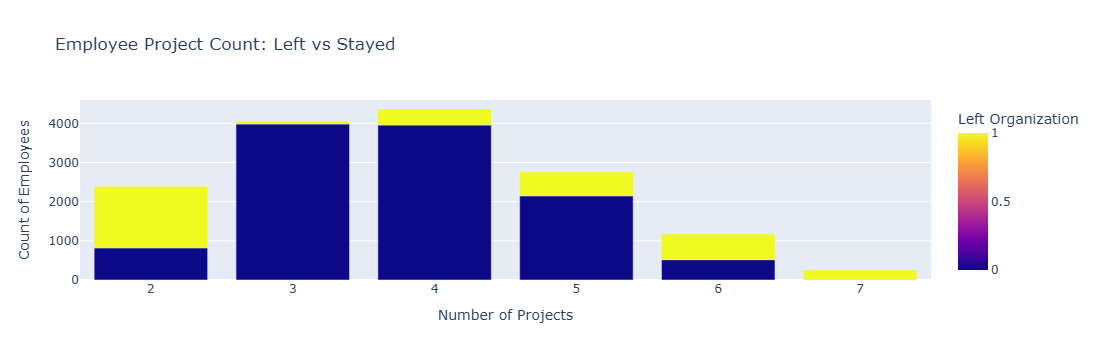

In [20]:
# Check if the required columns exist in the DataFrame
if 'number_project' in df.columns and 'left' in df.columns:
    # Create a grouped DataFrame for aggregation
    grouped_data = df.groupby(['number_project', 'left']).size().reset_index(name='count')

    # Create a bar plot using Plotly
    fig = px.bar(
        grouped_data,
        x='number_project',
        y='count',
        color='left',
        barmode='group',
        title='Employee Project Count: Left vs Stayed',
        labels={'left': 'Left Organization', 'number_project': 'Number of Projects'},
        color_discrete_map={0: 'blue', 1: 'red'}  # Optional: Customize colors
    )

    # Update layout for better readability
    fig.update_layout(
        xaxis_title="Number of Projects",
        yaxis_title="Count of Employees",
        legend_title="Employee Status",
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )

    # Display the interactive plot
    fig.show()
else:
    print("Error: Columns 'number_project' and/or 'left' are not present in the dataset.")

**The graph illustrates the distribution of employees based on the number of projects they worked on, grouped by whether they stayed or left the organization. It shows that employees with 3 to 5 projects had the highest counts overall. However, employees with extreme project counts (either very low, such as 2 projects, or very high, such as 6-7 projects) were more likely to leave the organization. This suggests that underutilization or overwork may contribute to employee attrition. Employees with a balanced workload (3-4 projects) had higher retention rates, indicating an optimal range of project involvement for organizational stability.**

# 3. Clustering

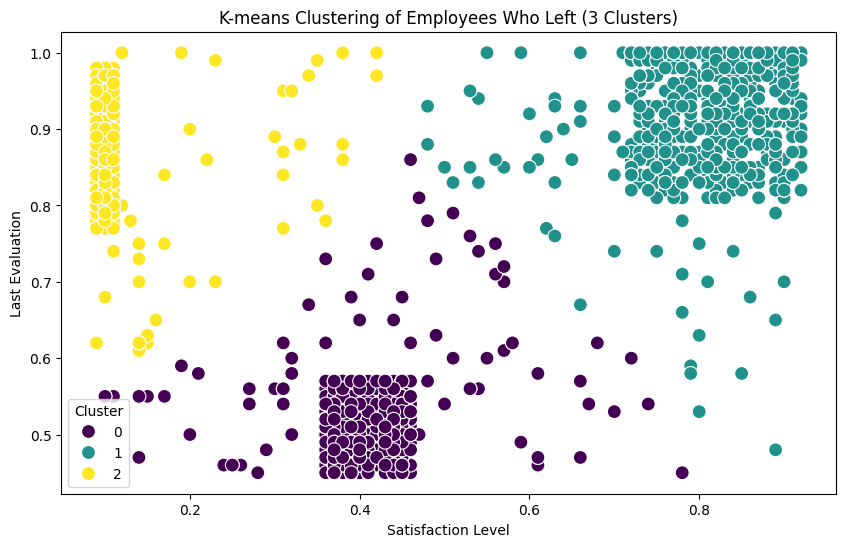

In [24]:
# Filter the dataset for employees who left
left_employees = df[df['left'] == 1][['satisfaction_level', 'last_evaluation']]

# Perform K-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
left_employees['cluster'] = kmeans.fit_predict(left_employees)

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=left_employees,
    x='satisfaction_level',
    y='last_evaluation',
    hue='cluster',
    palette='viridis',
    s=100
)
plt.title('K-means Clustering of Employees Who Left (3 Clusters)')
plt.xlabel('Satisfaction Level')
plt.ylabel('Last Evaluation')
plt.legend(title='Cluster')
plt.show()


## Thoughts on Employee Clusters Based on the Graph

1. **Cluster 0 (Purple)**:
   - Employees in this cluster have **low satisfaction levels** and **moderate to low evaluation scores**.
   - This group likely represents employees who left due to dissatisfaction and underperformance. 
   - Retention strategies could involve identifying causes of dissatisfaction, such as lack of recognition, poor working conditions, or inadequate management support.

2. **Cluster 1 (Green)**:
   - This group consists of employees with **high satisfaction levels** and **high evaluation scores**.
   - The departure of such employees is surprising and might stem from external factors like better job offers or lack of long-term growth in their current roles.
   - Companies should focus on improving employee engagement and offering competitive benefits to retain such valuable team members.

3. **Cluster 2 (Yellow)**:
   - Employees here exhibit **very low satisfaction** but **high evaluation scores**.
   - Despite being high performers, these employees left, which could indicate factors like burnout, overwork, or lack of alignment with company goals.
   - To retain such employees, it’s crucial to balance workload, provide career growth opportunities, and acknowledge their contributions.

### Overall Insights
The clustering highlights distinct reasons for employee turnover:
- Low satisfaction (Cluster 0) is a common driver of exits, often coupled with underperformance.
- High performers (Clusters 1 and 2) leave due to burnout or lack of growth opportunities, despite being satisfied with their roles.

# 4. Handling Class Imbalance

In [29]:
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [31]:
df['department'].unique()

array(['sales', 'accounting', 'hr', 'technical', 'support', 'management',
       'IT', 'product_mng', 'marketing', 'RandD'], dtype=object)

In [32]:
df['salary'].unique()

array(['low', 'medium', 'high'], dtype=object)

In [34]:
# Applying get_dummies to all categorical columns
df_dummies = pd.get_dummies(df, drop_first=True)

In [36]:
# Splitting data into features and targets
X = df_dummies.drop('left', axis=1)  
y = df_dummies['left']

In [37]:
# Performing stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=123
)

In [39]:
# Initializing SMOTE
smote = SMOTE(random_state=123)

# Applying SMOTE to the training data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# 5. Performing 5-fold cross validation/Model Training

### Logistic Regression

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78      9142
           1       0.77      0.81      0.79      9142

    accuracy                           0.78     18284
   macro avg       0.79      0.78      0.78     18284
weighted avg       0.79      0.78      0.78     18284



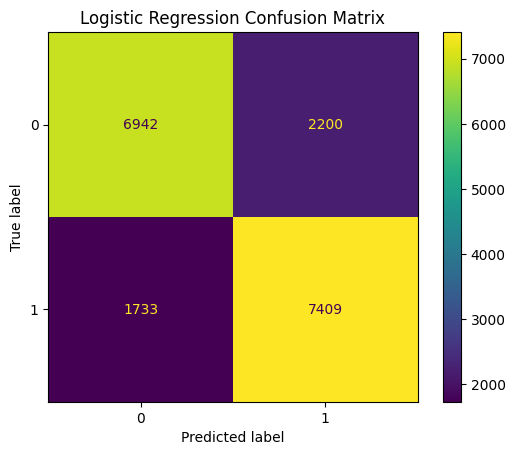

In [41]:
# Logistic Regression
log_reg = LogisticRegression(random_state=123)

# Performing 5-fold cross-validation and get predictions
y_pred_log_reg = cross_val_predict(log_reg, X_train_resampled, y_train_resampled, cv=5)

# Generating classification report
print("Logistic Regression Classification Report:")
print(classification_report(y_train_resampled, y_pred_log_reg))

# Plotting confusion matrix
ConfusionMatrixDisplay.from_predictions(y_train_resampled, y_pred_log_reg)
plt.title("Logistic Regression Confusion Matrix")
plt.show()

### Random Forest

Random Forest Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      9142
           1       0.99      0.97      0.98      9142

    accuracy                           0.98     18284
   macro avg       0.98      0.98      0.98     18284
weighted avg       0.98      0.98      0.98     18284



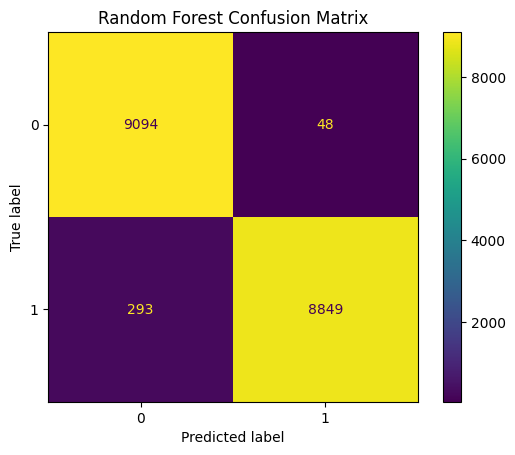

In [42]:
# Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=123)

# Performing 5-fold cross-validation and get predictions
y_pred_rf = cross_val_predict(rf_clf, X_train_resampled, y_train_resampled, cv=5)

# Generating classification report
print("Random Forest Classifier Classification Report:")
print(classification_report(y_train_resampled, y_pred_rf))

# Plotting confusion matrix
ConfusionMatrixDisplay.from_predictions(y_train_resampled, y_pred_rf)
plt.title("Random Forest Confusion Matrix")
plt.show()

### Gradient Boosting Forest Classifier

Gradient Boosting Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      9142
           1       0.97      0.94      0.96      9142

    accuracy                           0.96     18284
   macro avg       0.96      0.96      0.96     18284
weighted avg       0.96      0.96      0.96     18284



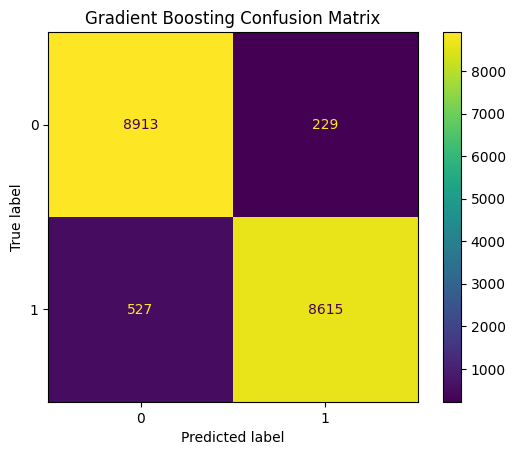

In [43]:
# Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(random_state=123)

# Performing 5-fold cross-validation and get predictions
y_pred_gb = cross_val_predict(gb_clf, X_train_resampled, y_train_resampled, cv=5)

# Generating classification report
print("Gradient Boosting Classifier Classification Report:")
print(classification_report(y_train_resampled, y_pred_gb))

# Plotting confusion matrix
ConfusionMatrixDisplay.from_predictions(y_train_resampled, y_pred_gb)
plt.title("Gradient Boosting Confusion Matrix")
plt.show()

# 6. Best Model

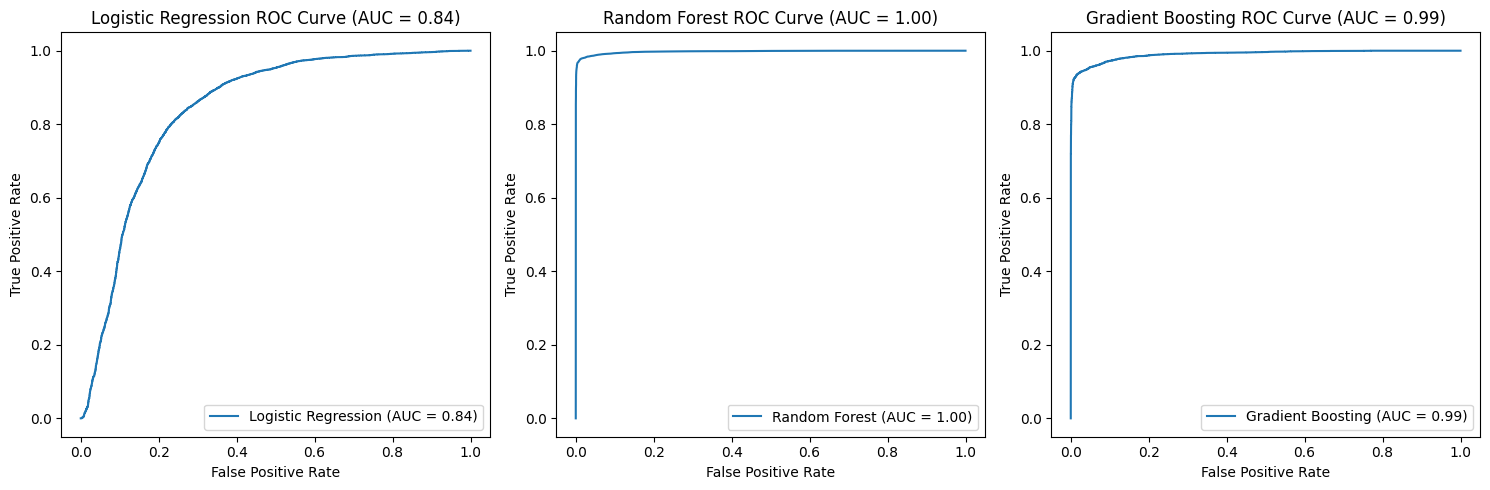

In [46]:
# Function to calculate and plot the ROC curve
def plot_roc_curve(model, X, y, label, ax):
    y_pred_prob = cross_val_predict(model, X, y, cv=5, method="predict_proba")[:, 1]
    fpr, tpr, _ = roc_curve(y, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name=label).plot(ax=ax)
    ax.set_title(f"{label} ROC Curve (AUC = {roc_auc:.2f})")

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot ROC curves for all models
plot_roc_curve(log_reg, X_train_resampled, y_train_resampled, "Logistic Regression", axes[0])
plot_roc_curve(rf_clf, X_train_resampled, y_train_resampled, "Random Forest", axes[1])
plot_roc_curve(gb_clf, X_train_resampled, y_train_resampled, "Gradient Boosting", axes[2])

plt.tight_layout()
plt.show()

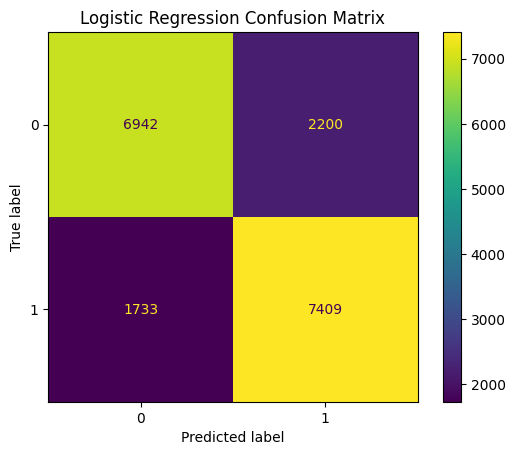

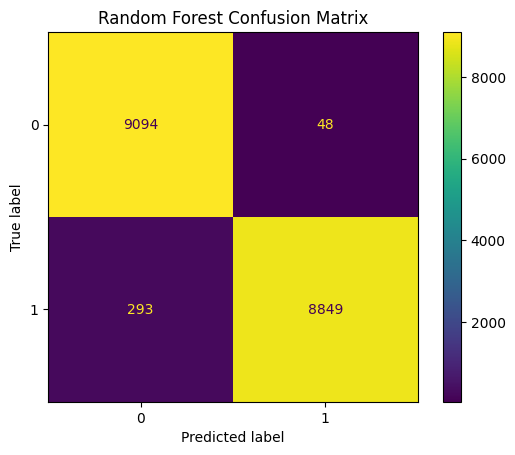

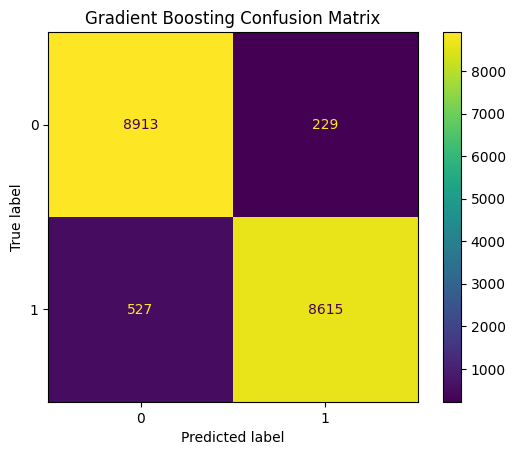

In [47]:
# Plotting confusion matrix
ConfusionMatrixDisplay.from_predictions(y_train_resampled, y_pred_log_reg)
plt.title("Logistic Regression Confusion Matrix")
plt.show()

# Plotting confusion matrix
ConfusionMatrixDisplay.from_predictions(y_train_resampled, y_pred_rf)
plt.title("Random Forest Confusion Matrix")
plt.show()

ConfusionMatrixDisplay.from_predictions(y_train_resampled, y_pred_gb)
plt.title("Gradient Boosting Confusion Matrix")
plt.show()

### Answer to Question 6.3: Recall or Precision?

Given the task of predicting employee churn, **Recall** is the more important metric. Here's why:

#### Importance of Recall:
- **Recall focuses on capturing as many actual positives (employees who left) as possible.** It ensures that employees at risk of leaving are identified by the model, even at the cost of some false positives.
- In an organizational context, failing to identify employees likely to leave can have significant consequences, such as increased hiring and training costs, disruptions in team dynamics, and productivity losses.

#### Why Not Precision?
- **Precision measures how many of the predicted positives are actually correct.** While it's important, the cost of false positives (e.g., identifying employees as likely to leave when they aren’t) is generally lower than the cost of false negatives (missing employees who will leave).
- False positives might result in unnecessary retention efforts, but this is a smaller issue compared to losing valuable employees due to missed predictions.

#### Evaluating Random Forest:
- The **Random Forest model** performs best with an **accuracy of 0.99** and an **AUC of 1.00**, indicating excellent overall performance.
- Since Recall is prioritized in churn prediction, check the Recall value from the confusion matrix and classification report for this model. If Recall is high (close to 1.0), it confirms the model's effectiveness in identifying employees likely to leave.

---

### Conclusion:
For the given problem, **Recall** should be the primary metric used to evaluate the Random Forest model. The high AUC score and accuracy support its overall performance, and its high Recall ensures that employees at risk of leaving are effectively identified.


# 7. Predicting probability of Employee turnover

In [49]:
# Fitting the model on the training data
rf_clf.fit(X_train_resampled, y_train_resampled)

# Predicting probabilities for the test dataset
y_prob_test = rf_clf.predict_proba(X_test)[:, 1]

# Adding the probabilities to the test dataset for categorization
X_test['Turnover_Probability'] = y_prob_test

# Displaying the first few rows of the test dataset with probabilities
X_test.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_low,salary_medium,Turnover_Probability
10627,0.98,0.77,3,191,2,0,0,0,0,0,0,0,0,1,0,0,0,1,0.00
2703,0.76,0.93,3,271,5,0,0,0,0,1,0,0,0,0,0,0,1,0,0.56
6059,0.70,0.93,3,185,4,0,0,0,1,0,0,0,0,0,0,0,0,1,0.10
3258,0.48,0.61,3,223,3,1,0,0,0,0,0,0,0,0,1,0,0,1,0.00
4565,0.57,0.90,3,144,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0.01


In [50]:
# Categorizing employees into risk zones
def categorize_zone(probability):
    if probability < 0.2:
        return "Safe Zone (Green)"
    elif 0.2 <= probability < 0.6:
        return "Low-Risk Zone (Yellow)"
    elif 0.6 <= probability < 0.9:
        return "Medium-Risk Zone (Orange)"
    else:
        return "High-Risk Zone (Red)"

X_test['Risk_Zone'] = X_test['Turnover_Probability'].apply(categorize_zone)

Safe Zone (Green)            2145
High-Risk Zone (Red)          652
Low-Risk Zone (Yellow)        147
Medium-Risk Zone (Orange)      56
Name: Risk_Zone, dtype: int64


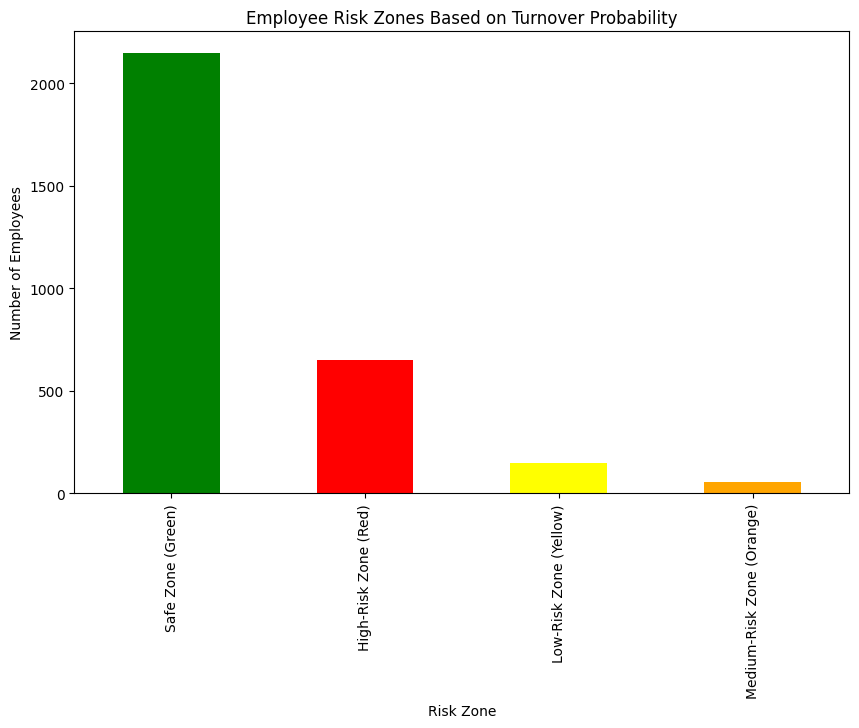

In [52]:
# Displaying the distribution of employees across zones
zone_distribution = X_test['Risk_Zone'].value_counts()
print(zone_distribution)

# Visualizing the distribution
zone_distribution.plot(kind='bar', color=['green', 'red', 'yellow', 'orange'], figsize=(10, 6))
plt.title("Employee Risk Zones Based on Turnover Probability")
plt.xlabel("Risk Zone")
plt.ylabel("Number of Employees")
plt.show()